In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path += ['..']
import re
from pathlib import Path
from datetime import datetime, timedelta
import pywt
import time
import somoclu
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import multiprocessing as mp
from ctypes import c_int32, c_bool
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
from matplotlib import cm, font_manager, gridspec
from mne.time_frequency import morlet
from scipy.signal import find_peaks, hilbert, welch, filtfilt
from scipy.stats import skew, entropy, zscore, ttest_ind, linregress
from scipy.optimize import curve_fit
from scipy.spatial import distance
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression

from readers import OpenEphysReader, BinaryReader, ExcelReader
from readers.mat_files import MatRecordingsParser
from detectors.shw import SharpWavesFinder
from detectors.motives import MotifFinder
import clusterers.som as clustering
from plotters.stellagama import StellaReviewPlotter, get_match_filter, StellaPlotter
from plotters.strikes import StrikesOE
import utils as utils
from scipy.io import savemat, loadmat
import ghostipy as gsp

In [2]:
rec_table = pd.read_excel('/media/sil1/Nitzan/Experiments/brainStatesWake.xlsx')
rec_table = rec_table.query('Exclude!=Exclude and recFormat in ["binaryRecording", "OERecording"]').set_index(['Animal', 'recNames']).drop(columns=['videoSync', 'eyeVideo', 'Breathing', 'sortedManually'])
#  and 26 <= tempMedian <= 28

In [3]:
rec_table.drop(columns=['folder', 'MEA_Layout', 'Date', 'spikes', 'VideoFiles', 'temperatureFile', 'Species', 'accelerometerCh', 'TempLogger_file', 'video_start_time', 'video_end_time'])

Exclude                        Remarks  MEAfiles  \
Animal recNames                                                         
SA15   testPC            NaN   made a copy to work on my PC       NaN   
PV87   hunterTest        NaN   made a copy to work on my PC       NaN   
SA15   Day1              NaN                 short, 1 video       NaN   
       Day2              NaN                        1 video       NaN   
       Day3              NaN                            NaN       NaN   
       Day4              NaN                            NaN       NaN   
       Day5              NaN                            NaN       NaN   
       Day6              NaN                            NaN       NaN   
       Day7              NaN                            NaN       NaN   
       Day8              NaN  short  OE (few hrs),FD videos       NaN   
       Day9              NaN                       no video       NaN   
       Day10             NaN                       no video       NaN   
       Day12             NaN                            NaN       NaN   
PV87   Post_surgery      NaN                            NaN       NaN   
       Hunter1           NaN                            NaN       NaN   
       Day1              NaN                            NaN       NaN   
       Hunter2           NaN                            NaN       NaN   
       Day2              NaN                            NaN       NaN   
       Hunter3           NaN                            NaN       NaN   
       Day3              NaN                            NaN       NaN   
       Hunter4           NaN                            NaN       NaN   
       Day4              NaN                            NaN       NaN   
       Day5              NaN                            NaN       NaN   
       Hunter6           NaN         no video saved from RL       NaN   
       Hunter7           NaN                            NaN       NaN   
       Day6              NaN                            NaN       NaN   
PV88   Hunter8           NaN                            NaN       NaN   
PV87   Day7              NaN                            NaN       NaN   
       Hunter9           NaN                            NaN       NaN   

                       recFormat  Sex  Video_notes  LFPCh_verified  \
Animal recNames                                                      
SA15   testPC        OERecording  NaN          NaN             NaN   
PV87   hunterTest    OERecording  NaN          NaN             NaN   
SA15   Day1          OERecording  NaN          NaN             NaN   
       Day2          OERecording  NaN          NaN             NaN   
       Day3          OERecording  NaN          NaN             NaN   
       Day4          OERecording  NaN          NaN             NaN   
       Day5          OERecording  NaN          NaN             NaN   
       Day6          OERecording  NaN          NaN             NaN   
       Day7          OERecording  NaN          NaN             NaN   
       Day8          OERecording  NaN          NaN             NaN   
       Day9          OERecording  NaN          NaN             NaN   
       Day10         OERecording  NaN          NaN             NaN   
       Day12         OERecording  NaN          NaN             NaN   
PV87   Post_surgery  OERecording  NaN          NaN             NaN   
       Hunter1       OERecording  NaN          NaN             NaN   
       Day1          OERecording  NaN          NaN             NaN   
       Hunter2       OERecording  NaN          NaN             NaN   
       Day2          OERecording  NaN          NaN             NaN   
       Hunter3       OERecording  NaN          NaN             NaN   
       Day3          OERecording  NaN          NaN             NaN   
       Hunter4       OERecording  NaN          NaN             NaN   
       Day4          OERecording  NaN          NaN             NaN   
       Day5          OERecording  NaN          NaN             NaN   
       

In [4]:
xls = ExcelReader(rec_table.reset_index(), is_debug=False, desired_fs=1000)
mfilt = get_match_filter()
print(f'len xls: {len(xls)}')

len xls: 29


In [14]:
sos = {}
for i in range(3, 13):
    try:
        rp = xls.get('PV87', f'Hunter{i}')
        so = StrikesOE(rp)
        so.load_signals()
        sos[str(rp)] = so
        # so.plot_signals()
    except Exception as exc:
        print(f'ERROR {rp}: {exc}')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

ERROR PV87,Hunter4: No results for PV87 and rec: Hunter5
ERROR PV87,Hunter6: 'DataFrame' object has no attribute 'time'


  0%|          | 0/17 [00:00<?, ?it/s]

ERROR PV87,Hunter7: No results for PV87 and rec: Hunter8


  0%|          | 0/15 [00:00<?, ?it/s]

ERROR PV87,Hunter9: No results for PV87 and rec: Hunter10
ERROR PV87,Hunter9: No results for PV87 and rec: Hunter11
ERROR PV87,Hunter9: No results for PV87 and rec: Hunter12


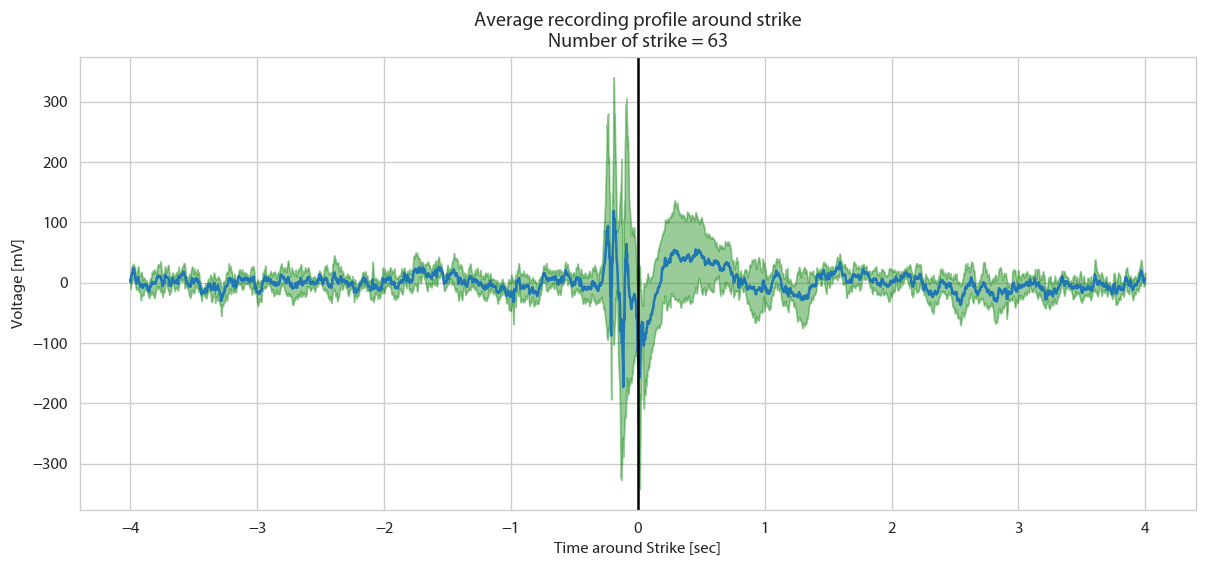

In [15]:
mean_seg = []
n = 0
for so in sos.values():
  m = np.vstack(so.segs).mean(axis=0)
  mean_seg.append(m)
  n += len(so.segs)

plt.figure(figsize=(12, 5), dpi=120)
y = np.vstack(mean_seg).mean(axis=0)
error = np.vstack(mean_seg).std(axis=0)
plt.plot(so.t, y)
plt.fill_between(so.t, y-error, y+error, color='green', alpha=0.4)
plt.axvline(0, color='k')
plt.xlabel('Time around Strike [sec]')
plt.ylabel('Voltage [mV]')
plt.title(f'Average recording profile around strike\nNumber of strike = {n}');

In [12]:
rp = xls.get('PV87', f'Hunter4')
so = StrikesOE(rp)
so.bf
so.behavior_events

strike  tongue  approach  strike_time  tongue_time  approach_time
0     4794    4781    4708.0   104.577185   104.356372     103.116554
1     6879    6863    6767.0   139.976023   139.704368     138.074351
2     8971    8952    8848.0   175.497335   175.174762     173.408568
3    11047   11031   10948.0   210.750164   210.478450     209.068707
4    13254   13238       NaN   248.225252   247.953612            NaN
5    15327   15310   15220.0   283.417175   283.128587     281.600862
6    17422   17410   17321.0   318.987064   318.783304     317.272321
7    19579   19567   19461.0   355.609617   355.405872     353.606508
8    21794   21776   21625.0   393.212660   392.907093     390.343267
9    21978   21826       NaN   396.336314   393.755926            NaN
10   24068   24058   23946.0   431.819626   431.649778     429.747955
11   26279   26271   26102.0   469.362491   469.226642     466.356805
12   28584   28577       NaN   508.499050   508.380222            NaN
13   30734   30722   30557.0   544.998954   544.795150     541.993683
14   32868   32854   32691.0   581.234819   580.997058     578.229427
15   34987   34965   34865.0   617.219603   616.845981     615.147665

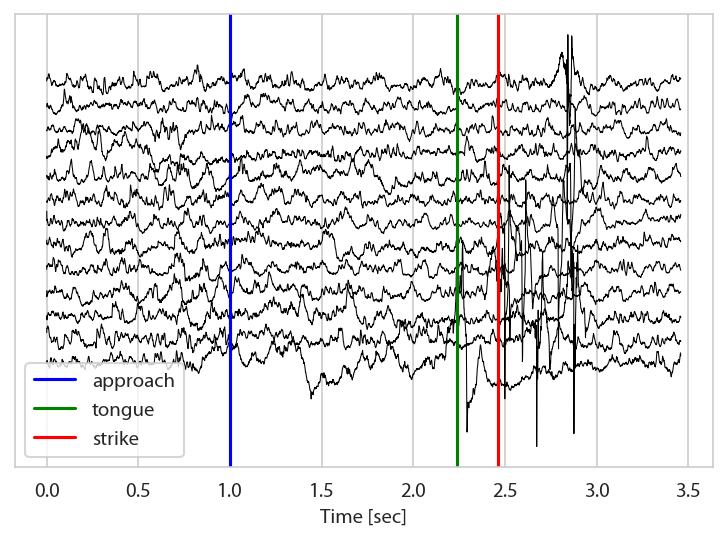

In [29]:
so.plot_behavior_events()

Finish calculating matrix profile with window of 2 seconds in 0.5 minutes.
Finish calculating matrix profile with window of 1.5 seconds in 0.6 minutes.


'/home/regev/PycharmProjects/lfp_clustering/output/motives/20230122/165523'

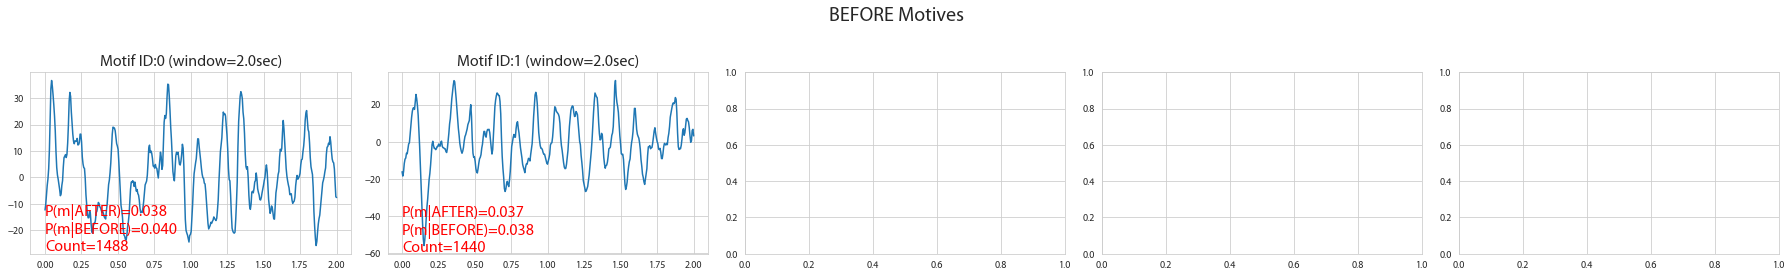

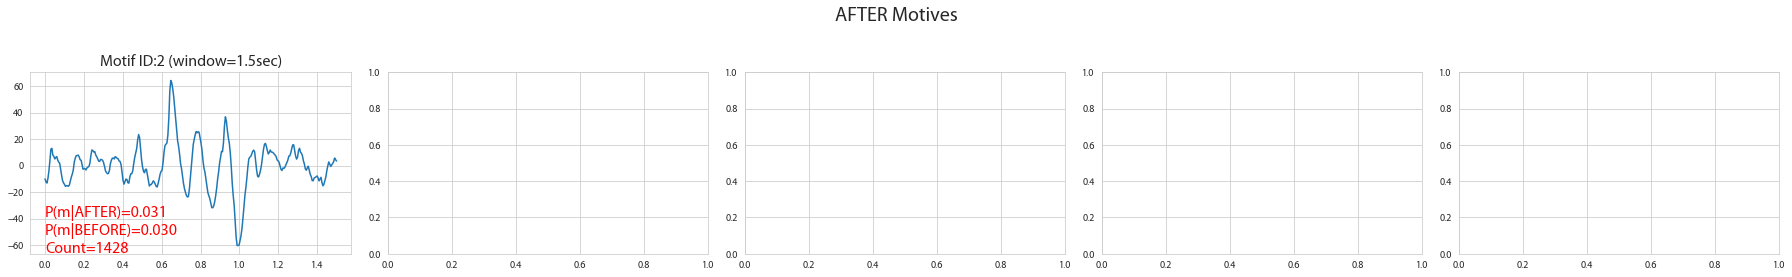

In [41]:
offset = 0.5
v, t = rp.read()
v = v.flatten()
for i, row in so.bf.iterrows():
  i1 = int(np.argmin(np.abs(t - (row.oe_time - offset))))
  i2 = int(np.argmin(np.abs(t - (row.oe_time + offset))))
  v[i1:i2] = None
mf = MotifFinder(rp, decimate_q=None, lowpass=None)
mf.search(v=v, is_cache=True, durations=(2, 1.5), bf=so.bf, is_avg_motives=True, is_remove_corr=False)

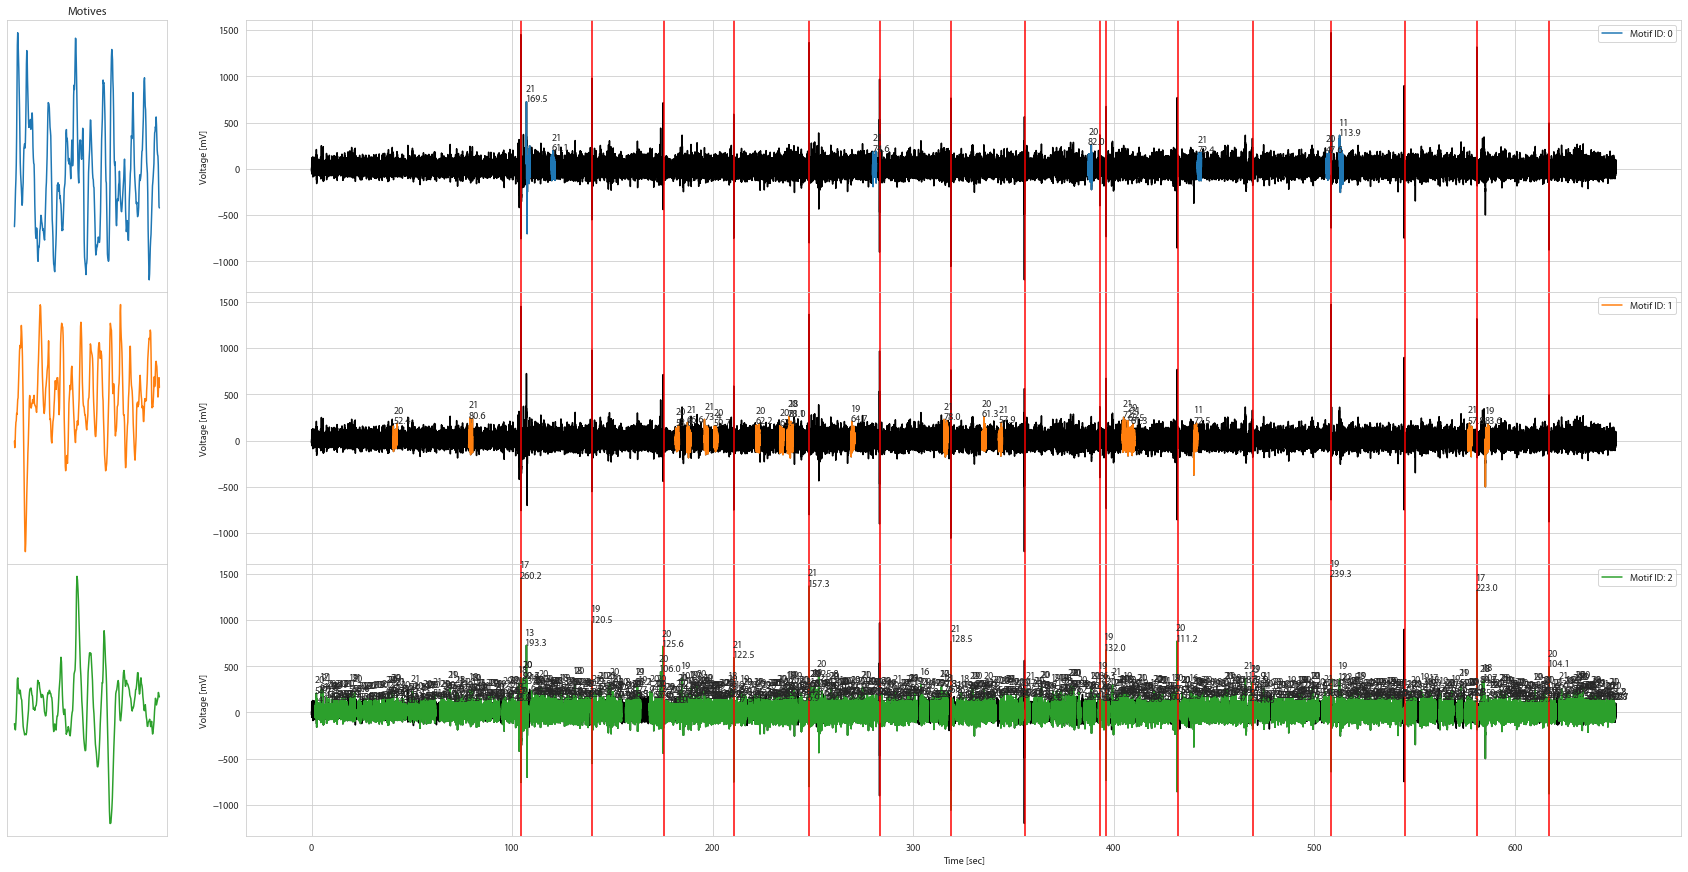

In [45]:
mf.plot_labelled_strikes(so.bf, max_dist=21)

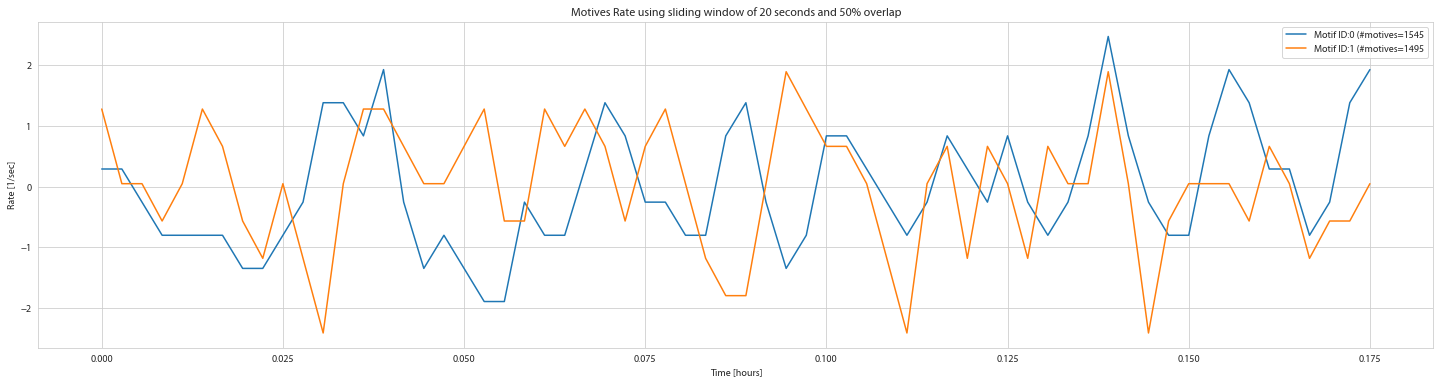

In [17]:
mf.plot_motif_rate_vs_time([0,1], max_dist=20, rate_window=20)

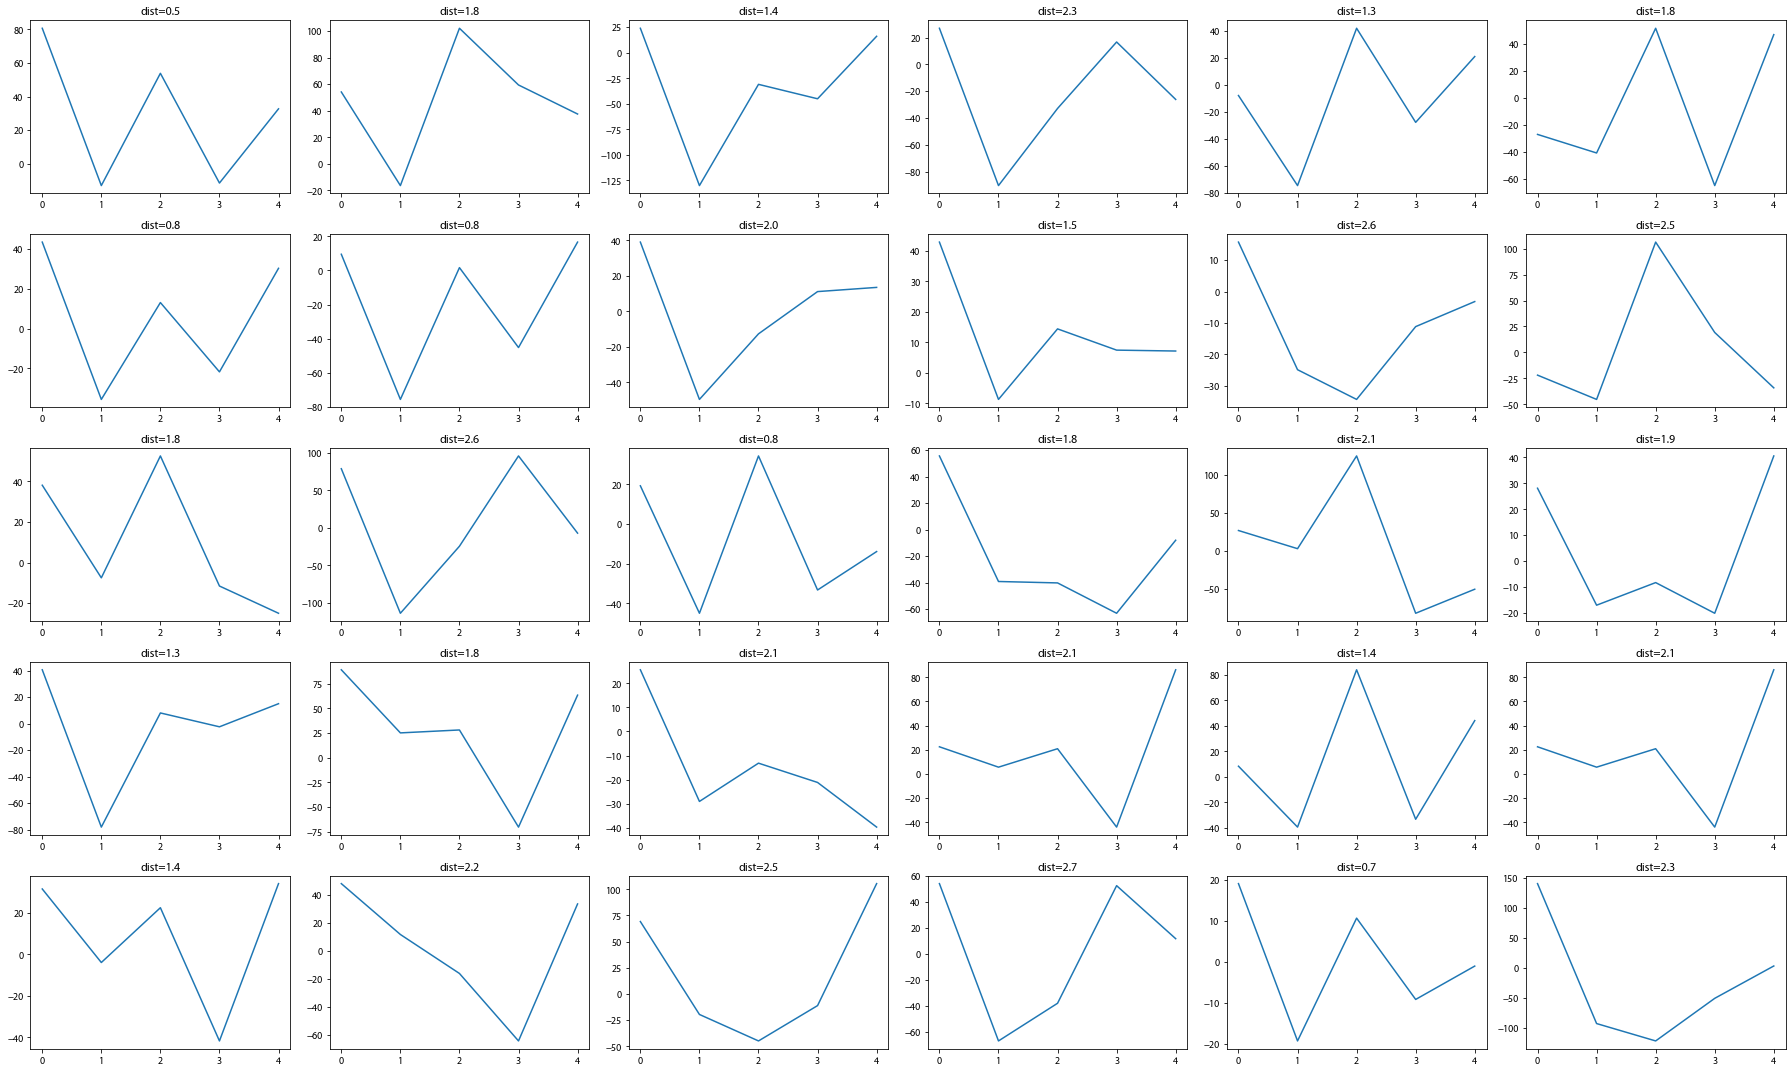

In [47]:
mf.plot_examples(0)

In [38]:
len(mf.motives)

2